<a href="https://colab.research.google.com/github/sarnavadatta/Finance-in-Python/blob/main/Mean_Variance_Efficient_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean-Variance Portfolio Optimization

This notebook demonstrates how to perform Mean-Variance Portfolio Optimization using historical stock data. The goal is to find portfolio weights that minimize risk (variance) for a given level of expected return, or maximize expected return for a given level of risk.

The notebook covers the following steps:

1.  **Data Loading and Preparation:**
    *   Download historical stock price data using the `yfinance` library.
    *   Calculate daily log returns.
    *   Annualize the mean returns and the covariance matrix.

2.  **Mean-Variance Optimization (Long-Only):**
    *   Formulate the optimization problem to minimize portfolio variance subject to constraints:
        *   Weights sum to 1 (fully invested).
        *   Weights are non-negative (no short selling).
        *   Achieve a target return.
    *   Solve the optimization problem using `cvxpy`.
    *   Calculate and print the resulting portfolio weights, expected return, and risk.

3.  **Efficient Frontier (Long-Only):**
    *   Iterate through a range of target returns to find the corresponding minimum risk portfolios.
    *   Plot the efficient frontier, showing the trade-off between risk and return for long-only portfolios.
    *   Identify and highlight the minimum risk point on the efficient frontier.

4.  **Mean-Variance Optimization (With Short Selling):**
    *   Formulate the optimization problem to minimize portfolio variance, allowing for short positions within specified bounds.
    *   Solve the optimization problem using `cvxpy`.
    *   Calculate and print the resulting portfolio weights, expected return, and risk for a specific target return with shorting constraints.

5.  **Efficient Frontier (With Bounded Short Selling):**
    *   Iterate through a range of target returns to find the corresponding minimum risk portfolios with bounded shorting allowed.
    *   Plot the efficient frontier for portfolios with bounded shorting constraints.
    *   Identify and highlight the minimum risk point on this efficient frontier.

## Requirements

*   numpy
*   pandas
*   yfinance
*   cvxpy
*   matplotlib

These libraries are imported at the beginning of the notebook.

## Usage

1.  Run the code cells sequentially.
2.  Modify the `tickers` list in the "Download stock data" cell to analyze different assets.
3.  Adjust the `start` and `end` dates to analyze different time periods.
4.  Experiment with the `target_return` in the optimization cells to find portfolios with different risk-return profiles.
5.  Modify the `short_bound` and `long_bound` variables in the short-selling sections to explore different shorting constraints.

## Output

The notebook outputs include:

*   DataFrames showing the downloaded stock data, log returns, and the calculated efficient frontiers (with and without shorting).
*   Plots of the efficient frontiers.
*   Printed results for specific optimized portfolios, including weights, expected return, and risk.

This notebook provides a practical example of applying Mean-Variance Optimization to construct investment portfolios.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import matplotlib.pyplot as plt

In [ ]:
# Download stock data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN']
data = yf.download(tickers, start='2020-01-01', end='2025-06-30')['Close']
log_returns = np.log(data / data.shift(1)).dropna()

[*********************100%***********************]  5 of 5 completed


$$
\mu = \bar{r}_{\text{daily}} \times 252
$$

$$
\Sigma = \text{Cov}_{\text{daily}} \times 252
$$

In [ ]:
# Calculate expected return and covariance
mu = log_returns.mean().values * 252  # annualized mean return
cov = log_returns.cov().values * 252  # annualized covariance
n_assets = len(tickers)

### Mean-Variance Optimization

We solve the following optimization problem:

$$
\begin{aligned}
\min_{w} \quad & w^T \Sigma w \\
\text{subject to} \quad & \sum_{i=1}^n w_i = 1 \\
& w_i \geq 0, \quad \text{for all } i \\
& \mu^T w \approx R_{\text{target}}
\end{aligned}
$$

where:
- $ w $ is the vector of asset weights,
- $ \Sigma $ is the annualized covariance matrix,
- $ \mu $ is the annualized expected return vector,
- $ R_{\text{target}} $ is the desired target return.


In [ ]:
# Set target return
target_return = 0.2  # Set target return to the maximum expected return

# Mean-Variance Optimization

# Portfolio weights (variables to optimize)
w = cp.Variable(n_assets)
# Objective: minimize portfolio variance (risk)
objective = cp.Minimize(cp.quad_form(w, cov))

constraints = [
              cp.sum(w) == 1, # Fully invested (weights sum to 1)
               w >= 0, # Long-only portfolio (no shorting)
               mu @ w >= target_return -1e-4, # Achieve approximately the target return
               mu @ w <= target_return +1e-4
              ]
prob = cp.Problem(objective, constraints)
prob.solve()

np.float64(0.08172404804708647)

In [ ]:
result = prob.solve()
print("Solver status:", prob.status)

Solver status: optimal


In [ ]:
# Results
weights = w.value
portfolio_std = np.sqrt(weights @ cov @ weights)
portfolio_ret = weights @ mu

print("Mean-Variance Efficient Portfolio")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {weights[i]:.4f}")

print(f"\nExpected Return: {portfolio_ret:.2%}")
print(f"Portfolio Risk (Volatility): {portfolio_std:.2%}")

📌 Mean-Variance Efficient Portfolio (Target Return 18%)
AAPL: 0.2427
MSFT: 0.0179
GOOGL: 0.1837
META: -0.0000
AMZN: 0.5557

Expected Return: 19.99%
Portfolio Risk (Volatility): 28.59%


In [ ]:
target_returns = np.linspace(0.18, 0.30, 50)
risks = []
weights_list = []

for tr in target_returns:
    w = cp.Variable(n_assets)
    objective = cp.Minimize(cp.quad_form(w, cov))
    constraints = [cp.sum(w) == 1, w >= 0, mu @ w == tr]
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve()
        risks.append(np.sqrt(w.value @ cov @ w.value))
        weights_list.append(w.value)
    except:
        risks.append(np.nan)
        weights_list.append([np.nan]*n_assets)


# Create a DataFrame
efficient_frontier_df = pd.DataFrame({
    'Target Return': target_returns,
    'Risk (Std Dev)': risks,
})

# Add weights to the DataFrame
weights_df = pd.DataFrame(weights_list, columns=[f'{ticker} Weight (%)' for ticker in tickers])
efficient_frontier_df = pd.concat([efficient_frontier_df, weights_df], axis=1)

# Convert weights to percentage and format to 2 decimal points
for ticker in tickers:
    col_name = f'{ticker} Weight (%)'
    efficient_frontier_df[col_name] = (efficient_frontier_df[col_name] * 100).round(2)

# Omit rows with NaN values
efficient_frontier_df.dropna(inplace=True)

efficient_frontier_df.head()


,Target Return,Risk (Std Dev),AAPL Weight (%),MSFT Weight (%),GOOGL Weight (%),META Weight (%),AMZN Weight (%)
0,0.180000,0.287987,32.29,23.24,31.43,0.0,13.04
1,0.182449,0.286467,31.30,20.60,29.82,0.0,18.27
2,0.184898,0.285295,30.32,17.96,28.22,0.0,23.51
3,0.187347,0.284476,29.33,15.32,26.61,0.0,28.74
4,0.189796,0.284013,28.34,12.68,25.00,0.0,33.97


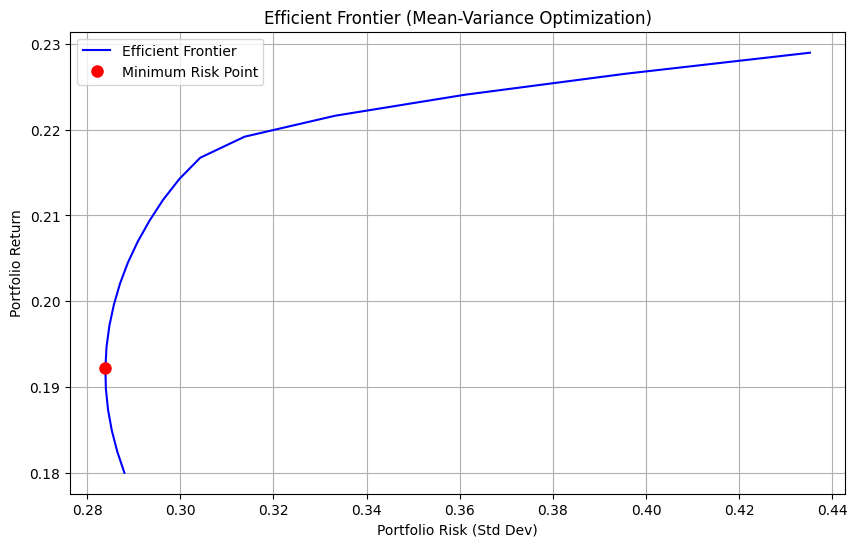


Minimum Risk Point: Risk = 28.39%, Return = 19.22%
Weights at Minimum Risk Point:
AAPL: 0.2736
MSFT: 0.1004
GOOGL: 0.2340
META: 0.0000
AMZN: 0.3921


In [ ]:
# Find the index of the minimum risk
min_risk_index = np.nanargmin(risks)

# Get the risk and return values at the minimum risk point
min_risk_point = (risks[min_risk_index], target_returns[min_risk_index])

# Plot the efficient frontier and add the minimum risk point
plt.figure(figsize=(10,6))
plt.plot(risks, target_returns, 'b-', label='Efficient Frontier')
plt.plot(min_risk_point[0], min_risk_point[1], 'ro', markersize=8, label='Minimum Risk Point') # Add red circle marker
plt.xlabel('Portfolio Risk (Std Dev)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier (Mean-Variance Optimization)')
plt.grid(True)
plt.legend()
plt.show()

print(f"\nMinimum Risk Point: Risk = {min_risk_point[0]:.2%}, Return = {min_risk_point[1]:.2%}")
print("Weights at Minimum Risk Point:")
min_risk_weights = weights_list[min_risk_index]
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {min_risk_weights[i]:.4f}")

### Mean-Variance Optimization with Short Selling

We solve:

$$
\begin{aligned}
\min_{w} \quad & w^T \Sigma w \\
\text{subject to} \quad & \sum_{i=1}^n w_i = 1 \\
& \mu^T w \approx R_{\text{target}} \\
& w_i \in \mathbb{R}, \quad \text{(shorting allowed)}
\end{aligned}
$$
Or with bounded shorting:
$$
\begin{aligned}
\min_{w} \quad & w^T \Sigma w \\
\text{subject to} \quad & \sum_{i=1}^n w_i = 1 \\
& \mu^T w \approx R_{\text{target}} \\
& -\delta \leq w_i \leq \gamma
& w_i \in \mathbb{R}, \quad \text{(shorting allowed)}
\end{aligned}
$$
Where $\delta$ and $\gamma$ are max short and long positions, respectively.



In [ ]:
target_return = 0.24
import cvxpy as cp

w = cp.Variable(n_assets)

# Objective: minimize portfolio variance
objective = cp.Minimize(cp.quad_form(w, cov))

# Constraints
constraints = [
    cp.sum(w) == 1,                        # Fully invested
    mu @ w >= target_return - 1e-4,        # Target return lower bound
    mu @ w <= target_return + 1e-4         # Target return upper bound
]

# Additional constraints for bounded shorting
delta = 0.3
gamma = 1.0
for i in range(n_assets):
    constraints.append(w[i] >= -delta)
    constraints.append(w[i] <= gamma)

# constraints.append(w >= -0.3)  # No more than 30% short in any single asset
# constraints.append(w <= 1.0)   # No more than 100% long in any asset

# Solve the problem
prob = cp.Problem(objective, constraints)
prob.solve()

result = prob.solve()
print("Solver status:", prob.status)


# Results
weights = w.value
portfolio_std = np.sqrt(weights @ cov @ weights)
portfolio_ret = weights @ mu

print("Mean-Variance Efficient Portfolio")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {weights[i]:.4f}")

print(f"\nExpected Return: {portfolio_ret:.2%}")
print(f"Portfolio Risk (Volatility): {portfolio_std:.2%}")


Solver status: optimal
Mean-Variance Efficient Portfolio
AAPL: 0.1224
MSFT: -0.3000
GOOGL: -0.1532
META: 0.3308
AMZN: 1.0000

Expected Return: 23.99%
Portfolio Risk (Volatility): 33.73%


In [ ]:
target_returns = np.linspace(0.18, 0.30, 50)

# Bounds
short_bound = -0.3
long_bound = 1.0
risks_shorting = []
weights_list_shorting = []

for tr in target_returns:
    w = cp.Variable(n_assets)
    objective = cp.Minimize(cp.quad_form(w, cov))
    constraints = [
        cp.sum(w) == 1,
        mu @ w >= tr - 1e-5,
        mu @ w <= tr + 1e-5,
        w >= short_bound,
        w <= long_bound
    ]
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve()
        # Only append results if the solver was successful
        if w.value is not None and prob.status in ["optimal", "optimal_near_it", "optimal_inaccurate"]:
             risks_shorting.append(np.sqrt(w.value.T @ cov @ w.value))
             weights_list_shorting.append(w.value)
        else:
            risks_shorting.append(np.nan)
            weights_list_shorting.append([np.nan]*n_assets) # Append NaNs if solve failed
    except Exception as e:
        print(f"Solver failed for target return {tr}: {e}")
        risks_shorting.append(np.nan)
        weights_list_shorting.append([np.nan]*n_assets)


# Create a DataFrame
efficient_frontier_shorting_df = pd.DataFrame({
    'Target Return': target_returns,
    'Risk (Std Dev)': risks_shorting,
})

# Add weights to the DataFrame
weights_shorting_df = pd.DataFrame(weights_list_shorting, columns=[f'{ticker} Weight (%)' for ticker in tickers])
efficient_frontier_shorting_df = pd.concat([efficient_frontier_shorting_df, weights_shorting_df], axis=1)

# Convert weights and returns to percentage and format to 2 decimal points
efficient_frontier_shorting_df['Target Return'] = (efficient_frontier_shorting_df['Target Return'] * 100).round(2)
efficient_frontier_shorting_df['Risk (Std Dev)'] = (efficient_frontier_shorting_df['Risk (Std Dev)'] * 100).round(2)

for ticker in tickers:
    col_name = f'{ticker} Weight (%)'
    efficient_frontier_shorting_df[col_name] = (efficient_frontier_shorting_df[col_name] * 100).round(2)

# Omit rows with NaN values (where the solver might have failed)
efficient_frontier_shorting_df.dropna(inplace=True)

efficient_frontier_shorting_df.head()

,Target Return,Risk (Std Dev),AAPL Weight (%),MSFT Weight (%),GOOGL Weight (%),META Weight (%),AMZN Weight (%)
0,18.00,28.39,31.31,20.46,31.52,-12.56,29.27
1,18.24,28.33,30.44,18.14,29.90,-11.10,32.62
2,18.49,28.29,29.57,15.82,28.28,-9.64,35.97
3,18.73,28.27,28.69,13.51,26.67,-8.19,39.32
4,18.98,28.28,27.82,11.19,25.05,-6.73,42.67


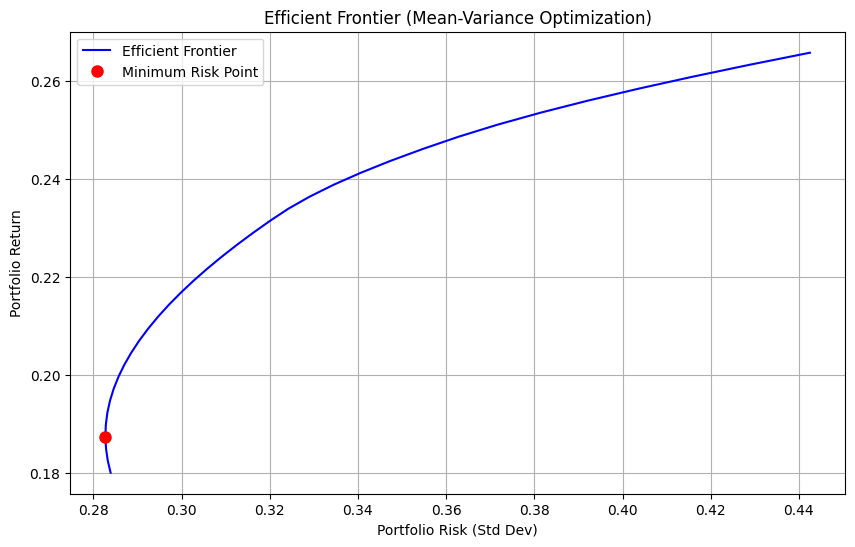


Minimum Risk Point: Risk = 28.27%, Return = 18.73%
Weights at Minimum Risk Point:
AAPL: 0.2869
MSFT: 0.1351
GOOGL: 0.2667
META: -0.0819
AMZN: 0.3932


In [ ]:
# Find the index of the minimum risk
min_risk_index = np.nanargmin(risks_shorting)

# Get the risk and return values at the minimum risk point
min_risk_point = (risks_shorting[min_risk_index], target_returns[min_risk_index])

# Plot the efficient frontier and add the minimum risk point
plt.figure(figsize=(10,6))
plt.plot(risks_shorting, target_returns, 'b-', label='Efficient Frontier')
plt.plot(min_risk_point[0], min_risk_point[1], 'ro', markersize=8, label='Minimum Risk Point') # Add red circle marker
plt.xlabel('Portfolio Risk (Std Dev)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier (Mean-Variance Optimization)')
plt.grid(True)
plt.legend()
plt.show()

print(f"\nMinimum Risk Point: Risk = {min_risk_point[0]:.2%}, Return = {min_risk_point[1]:.2%}")
print("Weights at Minimum Risk Point:")
min_risk_weights = weights_list_shorting[min_risk_index]
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {min_risk_weights[i]:.4f}")